# Evaluation of Random Forest Algorithm 

Following de decision tree of SIMs by Li and Heap ("*Spatial Interpolation methods applied in the environmental sciences: A review*", in Environmental Modelling & Software), one good strategy to stand with high spatial variance, availability of secondary variables are **Regression Trees**, such as Random Forest that build ensembles of them. 

In this notebook, Random Forest is evaluated on the task of spatially interpolate sensors data for NO2 in Newcastle Upon Tyne. The metric evaluated, R-squared, is used to plot learning curves. Also, feature importance levels are shown.

In [7]:
import sys
# sys.path.insert(0,'~/Repos/newcastle/air-quality/src')
sys.path.insert(0,'../src')
from v0 import *

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit, KFold
import matplotlib.pylab as plt
import seaborn as sns

### Data

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'
zx, zi = load_data__(DATA_FOLDER)
print('data loaded')

data loaded


In [3]:
zx, zi = resampling_sensors__(zx, zi, 'H')
zxtmp = RobustScaler().fit_transform(zx)
zitmp = np.sqrt(zi['Value'].values)

zxtmp.shape

(54944, 47)

In [32]:
variables =  {
    'sensors':['NO2','Temperature','O3'],
    'exogenous': ['primary','trunk','motorway','traffic_signals','hour','day','dow']
}

zxtmp = idw_features(zx, variables['sensors'])
zxtmp = zxtmp.join(zx[variables['exogenous']])

from sklearn.metrics import r2_score
r2_score(zi,zxtmp['idw_NO2'])

-0.18052015468933114

### Model

##### a) Random Forest

In [9]:
model = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=0.2)#.fit(zxtmp, zitmp)

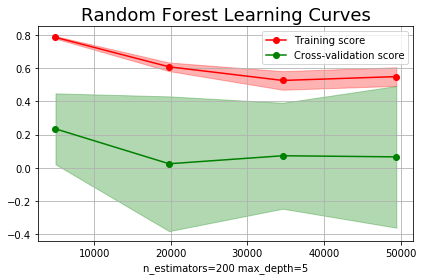

In [10]:
train_sizes, train_scores, test_scores = learning_curve(
                                            model, zxtmp, zitmp, scoring='r2', n_jobs=2,
                                            cv=KFold(n_splits=10),
#                                             cv=ShuffleSplit(n_splits=5, test_size=0.1, random_state=0),
                                            train_sizes=np.linspace(.1, 1.0, 4))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.title('Random Forest Learning Curves', fontsize=18)
plt.xlabel('n_estimators={} max_depth={}'.format(200,5))
plt.tight_layout()
plt.show()

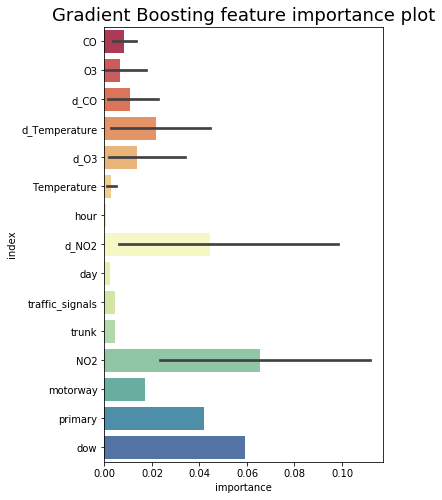

In [38]:
importances = model.feature_importances_
indices = zx.columns[np.argsort(importances)[::-1]]
f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

plt.figure(figsize=(5,8))
plt.title('Gradient Boosting feature importance plot',fontsize=18)
sns.barplot(y='index',x='importance',data=f, palette='Spectral');

##### b) Gradient Boosting

In [39]:
model = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=0.5).fit(zxtmp, zitmp)

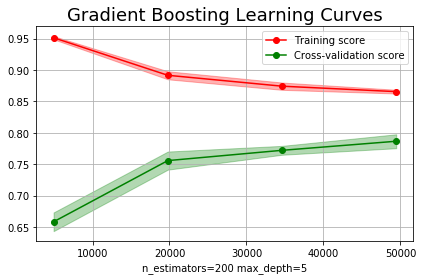

In [40]:
train_sizes, train_scores, test_scores = learning_curve(
                                            model, zxtmp, zitmp, scoring='r2', n_jobs=2,
                                            cv=ShuffleSplit(n_splits=5, test_size=0.1, random_state=0),
                                            train_sizes=np.linspace(.1, 1.0, 4))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.title('Gradient Boosting Learning Curves', fontsize=18)
plt.xlabel('n_estimators={} max_depth={}'.format(200,5))
plt.tight_layout()
plt.show()

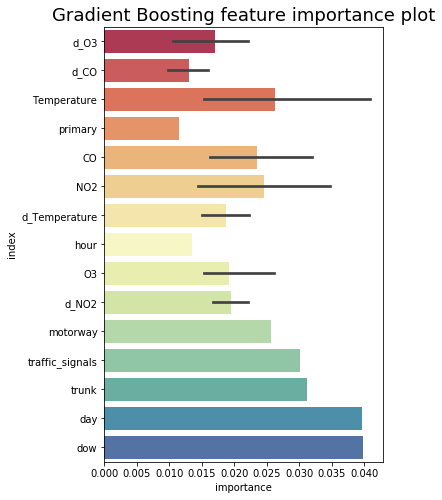

In [41]:
importances = model.feature_importances_
indices = zx.columns[np.argsort(importances)[::-1]]
f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

plt.figure(figsize=(5,8))
plt.title('Gradient Boosting feature importance plot',fontsize=18)
sns.barplot(y='index',x='importance',data=f, palette='Spectral');